# Master jupyter notebook for LANL - SlimBros Team

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## Preliminaries
Let's import everything we need:

In [53]:
import os
import gc
import eli5
import csv
import time
import random
import datetime
import warnings
import feather

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from sklearn import svm, neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score, ParameterGrid, train_test_split
from utils import generate_segment_start_ids, compare_methods
from features import gpi, create_all_features
from features import gpi_new, gpii_new, gpiii_new

#Configure the environment
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings('ignore')
random.seed(1013)

Load/compute the necessary features

In [57]:
compute_features = True 
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation
#train_data_format = 'csv'
train_data_format = 'feather'

## Training data

In [58]:
def load_train_data(file_format):
    """Load the training dataset."""
    print(f"Loading data from {file_format} file:", end="")
    if file_format.lower() == 'feather':
        train_df = feather.read_dataframe('../input/train.feather')
    else:
        train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16,
                                                            'time_to_failure': np.float32})
        feather.write_dataframe(train_df, '../input/train.feather')
    print("Done")
    return train_df

In [59]:
train = load_train_data(train_data_format)

Loading data from feather file:Done


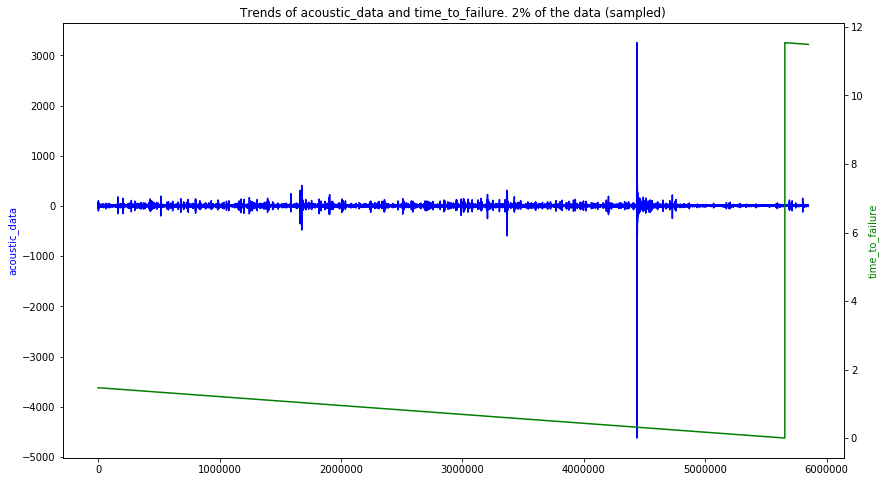

In [154]:
train_acoustic_data_small = train['acoustic_data'].values[:4350000+10*150000:]
train_time_to_failure_small = train['time_to_failure'].values[:4350000+10*150000:]

fig, ax1 = plt.subplots(figsize=(14, 8))
plt.title('Trends of acoustic_data and time_to_failure. 2% of the data (sampled)')
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')

del train_acoustic_data_small
del train_time_to_failure_small

In [61]:
time_to_failure_delta = np.diff(train['time_to_failure'])
init_times = np.where(time_to_failure_delta > 5)[0].tolist()
print(f"There are {len(init_times)} quakes on the training set.")
init_times = [0] + init_times

There are 16 quakes on the training set.


In [62]:
d = {'start_idx': init_times, 'end_idx': init_times[1:] + [len(time_to_failure_delta)]}
quakes = pd.DataFrame(data=d)
quakes.insert(2, 'valid', True)

Let's discard any quake that looks weird

In [63]:
#quakes['valid'][1] = False
#quakes['valid'][2] = False
#quakes['valid'][7] = False
#quakes['valid'][14] = False
#quakes['valid'][15] = False

## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [9]:
saved_files_present = (os.path.isfile('../tmp_results/X_tr.hdf') and 
                       os.path.isfile('../tmp_results/X_test.hdf') and 
                       os.path.isfile('../tmp_results/y_tr.hdf') )

In [64]:
if (not compute_features) and saved_files_present:
    print(f"Reading hdf files:", end="")
    X_tr = pd.read_hdf('../tmp_results/X_tr.hdf', 'data')
    X_test = pd.read_hdf('../tmp_results/X_test.hdf', 'data')
    y_tr = pd.read_hdf('../tmp_results/y_tr.hdf', 'data')  
    print("Done")
else:
    fs = 4000000 #Sampling frequency of the raw signal

    #Compute features for the training data
    segment_size = 150000
    #segment_start_ids = generate_segment_start_ids('uniform_no_jump', segment_size, train)
    segment_start_ids = generate_segment_start_ids('uniform', segment_size, train)
    X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
    y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])
    for idx in tqdm_notebook(range(len(segment_start_ids))):        
        seg_id = segment_start_ids[idx]
        seg = train.iloc[seg_id:seg_id + segment_size]
        create_all_features(idx, seg, X_tr, fs)
        y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    # Sanity check
    means_dict = {}
    for col in X_tr.columns:
        if X_tr[col].isnull().any():
            print(col)
            mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
            X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
            X_tr[col] = X_tr[col].fillna(mean_value)
            means_dict[col] = mean_value

    #Compute features for the test data
    submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
    X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
    for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
        seg = pd.read_csv('../input/test/' + seg_id + '.csv')
        create_all_features(seg_id, seg, X_test, fs)

    # Sanity check
    for col in X_test.columns:
        if X_test[col].isnull().any():
            X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
            X_test[col] = X_test[col].fillna(means_dict[col])
            
    X_tr.to_hdf('../tmp_results/X_tr.hdf', 'data')
    X_test.to_hdf('../tmp_results/X_test.hdf', 'data')
    y_tr.to_hdf('../tmp_results/y_tr.hdf', 'data')
    
    del segment_start_ids
    del means_dict
    del submission
    
    print("Done")


classic_sta_lta5_mean
classic_sta_lta7_mean



Done


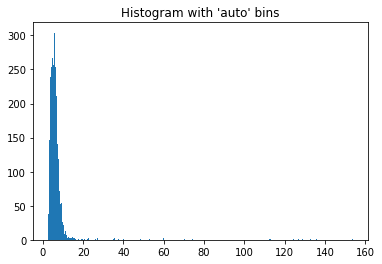

Count >100: 16


In [82]:
plt.hist(X_tr['std'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
print(f"Count >100: {np.sum(X_tr['std']>100)}")

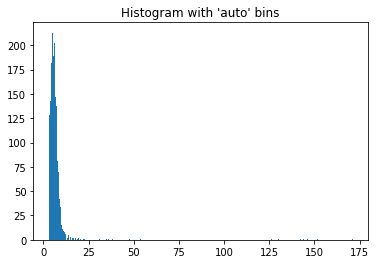

Count >100: 9


In [83]:
plt.hist(X_test['std'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
print(f"Count >100: {np.sum(X_test['std']>100)}")

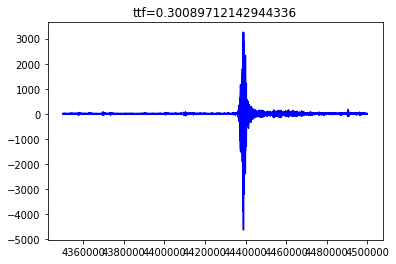

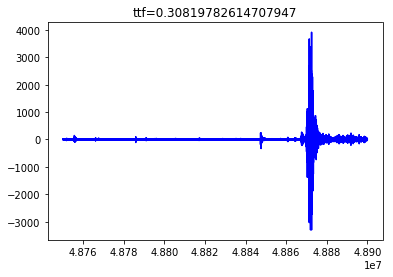

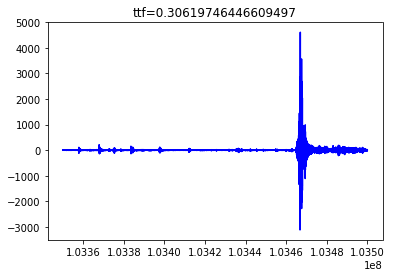

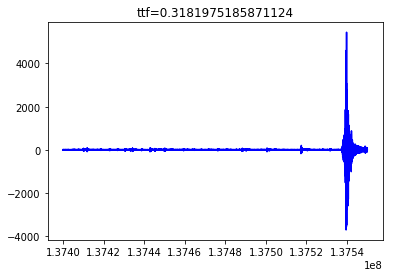

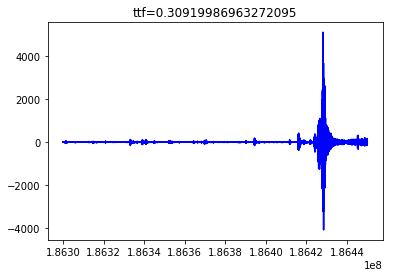

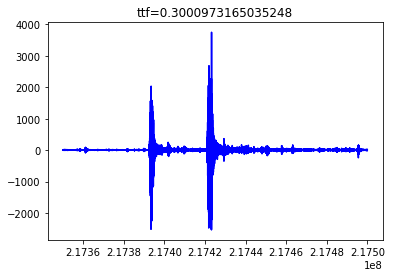

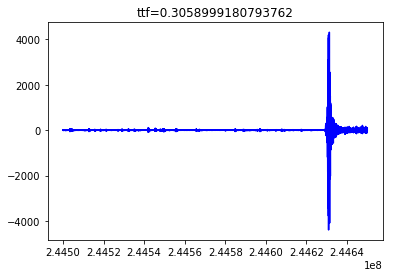

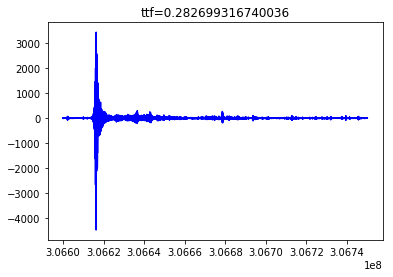

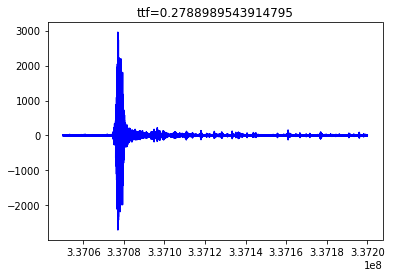

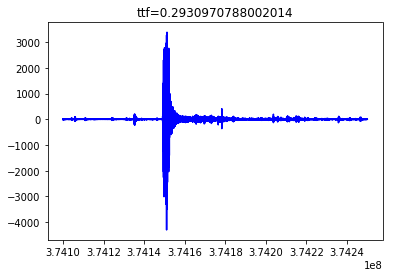

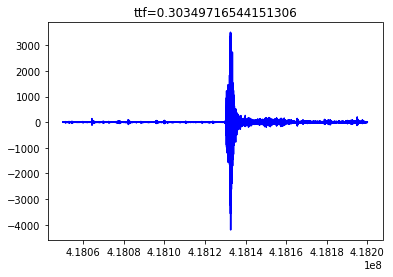

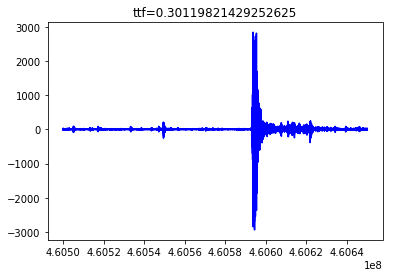

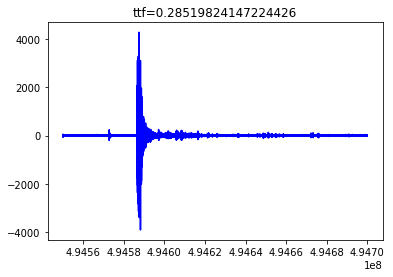

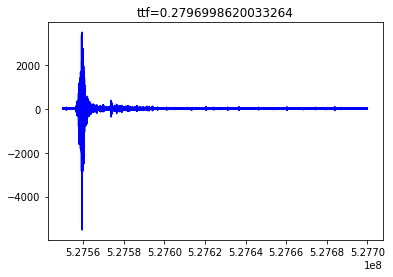

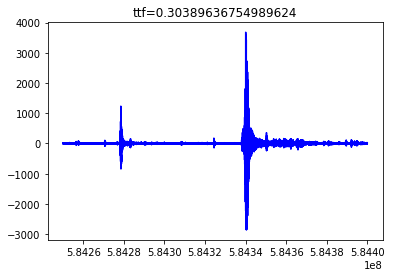

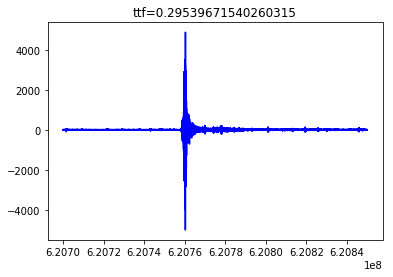

In [142]:
segment_start_ids = generate_segment_start_ids('uniform', segment_size, train)
XX = X_tr[X_tr['std']>100]
for i in XX.index:
    seg_id = segment_start_ids[i]
    seg = train.iloc[seg_id:seg_id + segment_size]
    ttf = seg['time_to_failure'].values[-1]
    
    plt.figure()
    plt.plot(seg, color='b')
    plt.title(f'ttf={ttf}')
    plt.show()

In [144]:
segment_start_ids = generate_segment_start_ids('uniform', segment_size, train)
XX = X_tr[X_tr['std']>100]

In [145]:
XX.index

Int64Index([  29,  325,  689,  916, 1242, 1449, 1630, 2044, 2247, 2494, 2787,
            3070, 3297, 3517, 3895, 4138],
           dtype='int64')

In [148]:
seg_id = segment_start_ids[29]

In [149]:
seg_id

4350000

## Scale data

In [11]:
alldata = pd.concat([X_tr, X_test])
scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)
X_train_scaled = alldata[:X_tr.shape[0]]
X_test_scaled = alldata[X_tr.shape[0]:]

## Building models

In [12]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False, force_positive=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    n_fold = folds.get_n_splits()
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'nn':
            dropout = params['dropout']
            num_layers = params['num_layers']
            num_neurons = params['num_neurons']
            activation_function = params['activation_function']
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(1024, input_dim=216, activation=activation_function))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(dropout))
            for l in range(num_layers):
                model.add(tf.keras.layers.Dense(num_neurons, activation=activation_function))
                model.add(tf.keras.layers.BatchNormalization())
                model.add(tf.keras.layers.Dropout(dropout))
            model.add(tf.keras.layers.Dense(1))
            model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
            EPOCHS = 1000
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

            history = model.fit(
                X_train,
                y_train,
                epochs=EPOCHS,
                validation_data = (X_valid, y_valid), 
                verbose=0,
                callbacks=[early_stop, PrintDot()])
            hist = pd.DataFrame(history.history)
            val_score = hist['val_mean_absolute_error'].iloc[-1]
            print(f'val_score={val_score}')
            plot_history(history)
        
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test).reshape(-1,)

            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=10000,
                      early_stopping_rounds=2000)
            
            y_pred_valid = model.predict(X_valid)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
            score = mean_absolute_error(y_valid, y_pred_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU', **params)
            model.fit(X_train,
                      y_train,
                      eval_set=(X_valid, y_valid),
                      cat_features=[],
                      use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)

            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)

        if model_type == 'gpi':
            y_pred_valid = gpi(X_valid, activation=params['activation']).values
            y_pred = gpi(X_test, activation=params['activation']).values
            
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if force_positive:
        prediction = prediction.clip(min=0)    
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
    
    print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
    if model_type == 'lgb':
        feature_importance['importance'] /= n_fold
        return oof, prediction, scores, feature_importance
    else:
        return oof, prediction, scores

In [13]:
n_fold = 5
folds_models = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

### LGBM (Gradient Boosting)
Gradient boosting that uses tree based learning algorithms.

To determine the best parameters, we have done a random search for different objective functions:

- Huber
![Huber](./hyperparam_search/lgbm/huber.png)

In [14]:
best_params_lgb_huber = {
    "objective": "huber",
    "boosting": "gbdt",
    "verbosity": -1,
    "num_leaves": 12,
    "min_data_in_leaf": 40,
    "max_depth": 8,
    "learning_rate": 0.005,
    "bagging_freq": 4,
    "bagging_fraction": 0.6,
    "bagging_seed": 11,
    "random_seed": 19,
    "metric": "mae",
    "reg_alpha": 0.47777777777777775,
    "reg_lambda": 0.47777777777777775
}

- Gamma
![Gamma](./hyperparam_search/lgbm/gamma.png)

In [15]:
best_params_lgb_gamma = {
    'num_leaves': 36,
    'min_data_in_leaf': 10,
    'max_depth': 12,
    'learning_rate': 0.005,
    'bagging_freq': 3,
    'bagging_fraction': 0.7166666666666667,
    'reg_alpha': 0.28888888888888886,
    'reg_lambda': 0.95,
    'objective': 'gamma',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'metric': 'mae',
    'bagging_seed': 11
}

- Fair
![Fair](./hyperparam_search/lgbm/fair.png)

In [16]:
best_params_lgb_fair = {
    'num_leaves': 8,
    'min_data_in_leaf': 60,
    'max_depth': 3,
    'learning_rate': 0.01,
    'bagging_freq': 5,
    'bagging_fraction': 0.6388888888888888,
    'reg_alpha': 0.19444444444444445,
    'reg_lambda': 0.95,
    'objective': 'fair',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'metric': 'mae',
    'bagging_seed': 11
}

- MAE
![MAE](./hyperparam_search/lgbm/mae.png)

In [17]:
best_params_lgb_mae = {
    "num_leaves": 8,
    "min_data_in_leaf": 100,
    "max_depth": 16,
    "learning_rate": 0.05,
    "bagging_freq": 3,
    "bagging_fraction": 0.6777777777777778,
    "reg_alpha": 0.19444444444444445,
    "reg_lambda": 0.1,
    "objective": "mae",
    "boosting": "gbdt",
    "verbosity": -1,
    "random_seed": 19,
    "metric": "mae",
    "bagging_seed": 11}

- Regression
![MAE](./hyperparam_search/lgbm/regression.png)

In [18]:
best_params_lgb_regression = {
    "num_leaves": 80,
    "min_data_in_leaf": 100,
    "max_depth": 8,
    "learning_rate": 0.01,
    "bagging_freq": 5,
    "bagging_fraction": 0.7166666666666667,
    "reg_alpha": 0.28888888888888886,
    "reg_lambda": 0.6666666666666666,
    "objective": "regression",
    "boosting": "gbdt",
    "verbosity": -1, "random_seed": 19,
    "metric": "mae",
    "bagging_seed": 11
}

In [19]:
params_lgb = best_params_lgb_huber

In [20]:
oof_lgb, prediction_lgb, scores_lgb, feature_importance_lgb = train_model(X=X_train_scaled,
                                                                          X_test=X_test_scaled,
                                                                          y=y_tr,
                                                                          folds=folds_models,
                                                                          params=params_lgb,
                                                                          model_type='lgb',
                                                                          show_scatter=False)

Fold 0 started at Mon May  6 20:55:41 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2600]	training's l1: 1.72512	valid_1's l1: 2.03206
Fold 1 started at Mon May  6 20:55:48 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2952]	training's l1: 1.69227	valid_1's l1: 2.02678
Fold 2 started at Mon May  6 20:55:56 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3824]	training's l1: 1.57165	valid_1's l1: 2.12214
Fold 3 started at Mon May  6 20:56:05 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2141]	training's l1: 1.81817	valid_1's l1: 1.88626
Fold 4 started at Mon May  6 20:56:12 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[4976]	training's l1: 1.49262	valid_1's l1: 2.04881
CV mean score: 2.0232, std: 0.

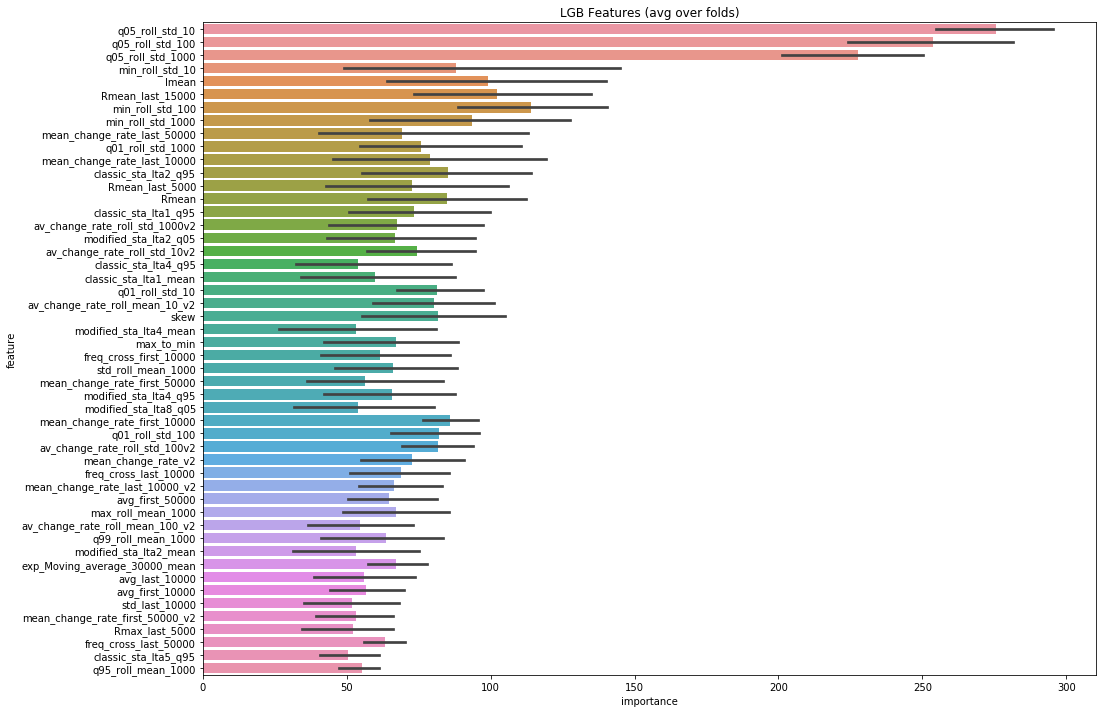

In [22]:
cols = feature_importance_lgb[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = feature_importance_lgb.loc[feature_importance_lgb.feature.isin(cols)]
plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
submission.to_csv('../output/submission_lgb.csv')

In [24]:
print(f'min={np.min(prediction_lgb)}')
print(f'max={np.max(prediction_lgb)}')
print(f'avg={np.mean(prediction_lgb)}')

min=0.977583568133463
max=10.2524996925506
avg=5.456814521703289


### XGBoost (Gradient Boosting)
Gradient boosting that uses tree based learning algorithms.

In [25]:
params_xgb = {
    'eta': 0.01, #Andrew uses 0.03
    'max_depth': 6, #Andrew uses 10
    'subsample': 0.5, #Andrew uses 0.9
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
} # CV mean score: 2.0801, std: 0.0711.
oof_xgb, prediction_xgb, scores_xgb = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_xgb,
                                                  model_type='xgb',
                                                  show_scatter=False)

Fold 0 started at Mon May  6 20:57:07 2019
[0]	train-mae:5.14356	valid_data-mae:5.12504
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[233]	train-mae:1.60799	valid_data-mae:2.04208

Fold 1 started at Mon May  6 20:57:09 2019
[0]	train-mae:5.16541	valid_data-mae:5.03919
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[255]	train-mae:1.57987	valid_data-mae:2.0389

Fold 2 started at Mon May  6 20:57:11 2019
[0]	train-mae:5.11564	valid_data-mae:5.24083
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:1.27448	valid_data-mae:2.15425
Stopping. Best iteration:
[342]	train-mae:1.43941	valid_data-mae:2.14654

Fold 3

In [28]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_xgb
submission.to_csv('../output/submission_xgb.csv')
print(f'min={np.min(prediction_xgb)}')
print(f'max={np.max(prediction_xgb)}')
print(f'avg={np.mean(prediction_xgb)}')

min=1.6022391080856324
max=10.75078067779541
avg=5.541507144372274


### SVM
Similar to NuSVC, for regression, uses a parameter nu to control the number of support vectors. However, unlike NuSVC, where nu replaces C, here nu replaces the parameter epsilon of epsilon-SVR.

In [29]:
#model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01) #original values
model = NuSVR(gamma='scale', nu=0.63, C=0.4469387755102041, tol=0.01)
oof_svr, prediction_svr, scores_svr = train_model(X=X_train_scaled,
                                      X_test=X_test_scaled,
                                      y=y_tr,
                                      folds=folds_models,
                                      params=None,
                                      model_type='sklearn',
                                      model=model,
                                      show_scatter=False)
del model

Fold 0 started at Mon May  6 21:31:17 2019
Fold 0. MAE: 2.0524.

Fold 1 started at Mon May  6 21:31:19 2019
Fold 1. MAE: 2.1062.

Fold 2 started at Mon May  6 21:31:22 2019
Fold 2. MAE: 2.1487.

Fold 3 started at Mon May  6 21:31:25 2019
Fold 3. MAE: 1.9615.

Fold 4 started at Mon May  6 21:31:28 2019
Fold 4. MAE: 2.0752.

CV mean score: 2.0688, std: 0.0626.


In [38]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_svr
submission.to_csv('../output/submission_svr.csv')
print(f'min={np.min(prediction_svr)}')
print(f'max={np.max(prediction_svr)}')
print(f'avg={np.mean(prediction_svr)}')

min=0.4773234993519558
max=10.033705855616333
avg=5.535939783059916


In [39]:
X_test.shape

(2624, 216)

### Catboost

In [31]:
params_cat = {
    'loss_function':'MAE'
}
oof_cat, prediction_cat, scores_cat = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_cat,
                                                  model_type='cat',
                                                  show_scatter=False)

Fold 0 started at Mon May  6 21:32:50 2019
Fold 1 started at Mon May  6 21:36:07 2019
Fold 2 started at Mon May  6 21:39:38 2019
Fold 3 started at Mon May  6 21:43:10 2019
Fold 4 started at Mon May  6 21:46:44 2019
CV mean score: 2.0281, std: 0.0773.


In [32]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_cat
submission.to_csv('../output/submission_cat.csv')
print(f'min={np.min(prediction_cat)}')
print(f'max={np.max(prediction_cat)}')
print(f'avg={np.mean(prediction_cat)}')

min=0.43558686146861875
max=9.395759728722442
avg=5.3219868057512665


### Kernel Ridge
This model combines regularized linear regression with a given kernel (radial basis in this case).

In [33]:
#model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01) #Original parameters
model = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
oof_r, prediction_r, scores_r = train_model(X=X_train_scaled,
                                            X_test=X_test_scaled,
                                            y=y_tr,
                                            folds=folds_models,
                                            params=None,
                                            model_type='sklearn',
                                            model=model,
                                            show_scatter=False)
del model

Fold 0 started at Mon May  6 21:50:17 2019
Fold 0. MAE: 2.0724.

Fold 1 started at Mon May  6 21:50:18 2019
Fold 1. MAE: 2.0736.

Fold 2 started at Mon May  6 21:50:18 2019
Fold 2. MAE: 2.1609.

Fold 3 started at Mon May  6 21:50:19 2019
Fold 3. MAE: 1.9481.

Fold 4 started at Mon May  6 21:50:19 2019
Fold 4. MAE: 2.0996.

CV mean score: 2.0709, std: 0.0693.


In [34]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_r
submission.to_csv('../output/submission_r.csv')
print(f'min={np.min(prediction_r)}')
print(f'max={np.max(prediction_r)}')
print(f'avg={np.mean(prediction_r)}')

min=4.8375659305683e-05
max=10.486261998993564
avg=5.728447747050886


### Genetic Program Model
Genetic programming model from https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model?scriptVersionId=10629478

In [35]:
params_gpi = {
    'activation':'tanh'
}
oof_gpi, prediction_gpi, scores_gpi = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  model_type='gpi',
                                                  params=params_gpi,
                                                  show_scatter=False)

Fold 0 started at Mon May  6 21:50:20 2019
Fold 1 started at Mon May  6 21:50:21 2019
Fold 2 started at Mon May  6 21:50:22 2019
Fold 3 started at Mon May  6 21:50:22 2019
Fold 4 started at Mon May  6 21:50:23 2019
CV mean score: 1.8985, std: 0.0738.


In [36]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_gpi
submission.to_csv('../output/submission_gpi.csv')
print(f'min={np.min(prediction_gpi)}')
print(f'max={np.max(prediction_gpi)}')
print(f'avg={np.mean(prediction_gpi)}')

4.017


min=0.7054949230108498
max=9.940440855295043
avg=5.464327292690391


### Random Forest
This regressor fits many decision trees with different subsets of the original data and average the predictions between them.

In [ ]:
params_rf = {
    'max_depth': 12, #8,
    'max_features': 'log2', #'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 4 #6
} #CV mean score: 2.0448, std: 0.0793.
model = RandomForestRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **params_rf)
oof_rf, prediction_rf, scores_rf = train_model(X=X_train_scaled,
                                               X_test=X_test_scaled,
                                               y=y_tr,
                                               folds=folds_models,
                                               params=params_rf,
                                               model_type='sklearn',
                                               model=model,
                                               show_scatter=False)
del model

In [37]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_rf
submission.to_csv('../output/submission_rf.csv')
print(f'min={np.min(prediction_rf)}')
print(f'max={np.max(prediction_rf)}')
print(f'avg={np.mean(prediction_rf)}')

NameError: name 'prediction_rf' is not defined

### Extremely Randomized Trees


In [ ]:
params_ex = {
    'max_depth': 12,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4
}
model = ExtraTreesRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **params_ex)
oof_ex, prediction_ex, scores_ex = train_model(X=X_train_scaled,
                                               X_test=X_test_scaled,
                                               y=y_tr,
                                               folds=folds_models,
                                               params=params_ex,
                                               model_type='sklearn',
                                               model=model,
                                               show_scatter=False)
del model

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_ex
submission.to_csv('../output/submission_ex.csv')
print(f'min={np.min(prediction_ex)}')
print(f'max={np.max(prediction_ex)}')
print(f'avg={np.mean(prediction_ex)}')

### Ada Boost
AdaBoost begins by fitting a base estimator on the original dataset and then fits additional copies on the same dataset. At each iteration (estimator), the weights of instances are adjusted according to the error of the last prediction. It's similar to the next model, but gradient boosting fits additional estimator copies on the current error and not on the original dataset.

In [ ]:
params_ada = {
    'learning_rate': 0.001
}
base = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
model = AdaBoostRegressor(base_estimator=base, n_estimators=100, **params_ada)
oof_ada, prediction_ada, scores_ada = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_ada,
                                                  model_type='sklearn',
                                                  model=model,
                                                  show_scatter=False)
del base
del model

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_ada
submission.to_csv('../output/submission_ada.csv')
print(f'min={np.min(prediction_ada)}')
print(f'max={np.max(prediction_ada)}')
print(f'avg={np.mean(prediction_ada)}')

### KNN

In [ ]:
#model = neighbors.KNeighborsRegressor()
#parameter_grid = {'n_neighbors': [10, 20, 25, 30, 35, 50]}
#grid_search = GridSearchCV(model, param_grid=parameter_grid,
#                           cv=folds_models,
#                           scoring='neg_mean_absolute_error',
#                           n_jobs=-1)
#grid_search.fit(X_train_scaled, y_tr)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))
#model = neighbors.KNeighborsRegressor(**grid_search.best_params_)
model = neighbors.KNeighborsRegressor(n_neighbors=30)
oof_knn, prediction_knn, scores_knn = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_knn,
                                                  model_type='sklearn',
                                                  model=model,
                                                  show_scatter=False)
del model

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_knn
submission.to_csv('../output/submission_knn.csv')
print(f'min={np.min(prediction_knn)}')
print(f'max={np.max(prediction_knn)}')
print(f'avg={np.mean(prediction_knn)}')

### Neural Network

Helper functions

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        else:
            print('.', end='')

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()
    plt.grid()
    plt.show()

#### FC model (all_features)x256x1
The following model is a fully-connected neural network that uses all the features from the training set.

Structure:
- Input layer
- Fully connected layer of 256 neurons with tanh activation
- Output layer with linear activation
![(all_features)x256x1 model](./figures/all_featuresx256x1.png)

In [ ]:
activation_function = 'tanh'
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,
                                input_dim=X_train_scaled.shape[-1],
                                activation=activation_function))
model.add(tf.keras.layers.Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(lr = 0.001, decay = 0.001 / 32)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])
EPOCHS = 250
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)
history = model.fit(
    X_train_scaled,
    y_tr,
    validation_split=0.2,
    epochs=EPOCHS,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop, PrintDot()])
hist = pd.DataFrame(history.history)
val_score = hist['val_mean_absolute_error'].iloc[-1]

#Show results
print(f'val_score={val_score}')
plot_history(history)

y_pred = model.predict(X_train_scaled).reshape(-1,)
fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y_tr, y_pred, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(y_pred, color='orange')

#Save results
print(model.summary())
tf.keras.utils.plot_model(model, to_file='./figures/all_featuresx256x1.png', show_shapes=True, show_layer_names=True)

# Housekeeping
del model
tf.keras.backend.clear_session()

#### Ensemble NN model with FC 5x256x1 networks
The following model is an ensemble of small fully-connected neural networks. Each small neural network uses 5 features from the training set. The features are selected from exhaustive search using the script `feature_search_nn_5x256x1.py`.

Structure of each NN:
- Input layer
- Fully connected layer of 5 neurons with tanh activation
- Output layer with leaky ReLU
![5x256x1.png model](./figures/5x256x1.png)

Ensemble:
- Uses `num_single_nets` small networks
- Weighted average using the inverse of the validation scores (`val_score`)

In [ ]:
#out_path = '../output/search_gdi_features_nn_5x256x1_tanh_linear/'
out_path = '../output/search_all_features_nn_5x1x1_tanh_linear/'
all_files = [f for f in os.listdir(out_path) if os.path.isfile(os.path.join(out_path, f))]
li = []
for f in all_files:
    df = pd.read_csv(os.path.join(out_path, f), index_col=None, header=0)
    li.append(df)
results_nn = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
num_single_nets = 256
results_nn_sorted = results_nn.sort_values(by=['val_score']).iloc[0:num_single_nets]

In [ ]:
results_nn_sorted.head()

In [ ]:
predictions = np.zeros((num_single_nets,len(X_test_scaled)))
oofs = np.zeros((num_single_nets,len(X_train_scaled)))
scores = []
for i in tqdm_notebook(range(num_single_nets)):
    nn_features_list = [results_nn_sorted['f1'].iloc[i],
                        results_nn_sorted['f2'].iloc[i],
                        results_nn_sorted['f3'].iloc[i],
                        results_nn_sorted['f4'].iloc[i],
                        results_nn_sorted['f5'].iloc[i]]
    X_train_nn = X_train_scaled[nn_features_list]
    X_test_nn = X_test_scaled[nn_features_list]
    print(f"Building FC-NN {i}. Features considered:")  
    print(nn_features_list)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1,
                                    input_dim=X_train_nn.shape[-1],
                                    activation='tanh'))
    model.add(tf.keras.layers.Dense(1,
                                    activation='linear'))

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    EPOCHS = 100
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)
    history = model.fit(
        X_train_nn,
        y_tr,
        validation_split=0.2,
        epochs=EPOCHS,
        shuffle=True,
        verbose=0,
        callbacks=[early_stop, PrintDot()])
    hist = pd.DataFrame(history.history)
    val_score = hist['val_mean_absolute_error'].iloc[-1]
    scores.append(val_score)
    print(f'val_score={val_score}')

    oofs[i] = model.predict(X_train_nn).reshape(-1,)
    predictions[i] = model.predict(X_test_nn).reshape(-1,)
    
    #Save results
    if i==1:
        print(model.summary())
        tf.keras.utils.plot_model(model, to_file='./figures/5x256x1.png', show_shapes=True, show_layer_names=True)

    #Housekeeping
    del model
    tf.keras.backend.clear_session()
    

In [ ]:
predictions = predictions.clip(min=0)
oofs = oofs.clip(min=0)

In [ ]:
#Combine estimations
model_confidence = 1/np.array(scores)
model_confidence /= np.sum(model_confidence)
prediction = np.average(predictions.T, weights=model_confidence, axis=1)
oof = np.average(oofs.T, weights=model_confidence, axis=1)

plt.figure()
plt.plot(model_confidence)

#Show results
fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y_tr, oof, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(oof, color='orange')
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction
submission.to_csv('../output/submission_nn_ensemble_5x1x1_tanh_Linear.csv')

#### DNN model

In [ ]:
params_dnn = {
    'dropout': 0.70,
    'num_layers': 2,
    'num_neurons': 90,
    'activation_function': 'tanh'
}
oof_dnn, prediction_dnn, score_mean_dnn, score_std_dnn = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=params_dnn,
                                                                     model_type='nn',
                                                                     show_scatter=True)

# Compare models

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()
scores_df['LGBMRegressor'] = scores_lgb
scores_df['XGBRegressor'] = scores_xgb
scores_df['NuSVR'] = scores_svr
scores_df['CatBoostRegressor'] = scores_cat
scores_df['Ridge'] = scores_r
scores_df['GPI'] = scores_gpi
scores_df['RandomForestRegressor'] = scores_rf
scores_df['ExtraTreesRegressor'] = scores_ex
scores_df['AdaBoostRegressor'] = scores_ada
scores_df['KNN'] = scores_knn

ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
#ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('Score');

## Feature reduction

### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, y_tr, test_size=0.1)
model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, top=50, feature_names=X_train_scaled.columns.values.tolist())

In [ ]:
top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb_top, prediction_lgb_top, scores_lgb_top, feature_importance_lgb_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

In [ ]:
X_train_scaled_uncorr = X_train_scaled.copy()
X_test_scaled_uncorr = X_test_scaled.copy()

In [ ]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X_train_scaled_uncorr.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X_train_scaled_uncorr = X_train_scaled_uncorr.drop(to_drop, axis=1)
X_test_scaled_uncorr = X_test_scaled_uncorr.drop(to_drop, axis=1)

print(X_train_scaled.shape)
print(X_train_scaled_uncorr.shape)

oof_lgb_uncorr, prediction_lgb_uncorr, scores_lgb_uncorr, feature_importance_lgb_uncorr = train_model(
    X=X_train_scaled_uncorr,
    X_test=X_test_scaled_uncorr,
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)
cols = feature_importance_lgb_uncorr[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance_lgb_uncorr.loc[feature_importance_lgb_uncorr.feature.isin(cols)]
plt.figure(figsize=(16, 20));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled_uncorr, y_tr, test_size=0.1)
model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, top=50, feature_names=X_train_scaled_uncorr.columns.values.tolist())

In [ ]:
top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb_uncorr_top, prediction_lgb_uncorr_top, scores_lgb_uncorr_top, feature_importance_lgb_uncorr_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()
scores_df['LGB'] = scores_lgb
scores_df['LGB_top'] = scores_lgb_top
scores_df['LGB_uncorr'] = scores_lgb_uncorr
scores_df['LGB_uncorr_top'] = scores_lgb_uncorr_top
scores_df['XGB'] = scores_xgb
scores_df['SVR'] = scores_svr
scores_df['CatBoost'] = scores_cat
scores_df['Ridge'] = scores_r
scores_df['GPI'] = scores_gpi
scores_df['RandomForest'] = scores_rf
scores_df['ExtraTrees'] = scores_ex
scores_df['AdaBoost'] = scores_ada
scores_df['KNN'] = scores_knn

ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('Score');

## Stacking and blending
And now let's try stacking :) We can use the same function for it.

In [ ]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_r,
                         oof_cat, oof_gdi, oof_rf, oof_ex,
                         oof_ada]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'r', 'cat', 'gdi', 'rf', 'ex', 'ada'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_r,
                        prediction_cat, prediction_gdi, prediction_rf, prediction_ex,
                        prediction_ada]).transpose()
test_stack = pd.DataFrame(test_stack)

In [ ]:
params_lgb_stack = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 8, #54,
    'min_data_in_leaf': 100, #79,
    'max_depth': 5, #-1,
    'learning_rate': 0.01, #0.01,
    'bagging_freq': 5, #5,
    'bagging_fraction': 0.7555555555555555, #0.8126672064208567,
    'bagging_seed': 11,
    'metric': 'mae',
    'reg_alpha': 0.95, #0.1302650970728192,
    'reg_lambda': 0.19444444444444445 #0.3603427518866501
}
oof_lgb_stack, prediction_lgb_stack, score_mean_lgb_stack, score_std_lgb_stack, feature_importance_lgb_stack = train_model(
    X=train_stack,
    X_test=test_stack,
    y=y_tr,
    folds=folds_models,
    params=params_lgb_stack,
    model_type='lgb')

In [ ]:
cols = feature_importance_lgb_stack[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance_lgb_stack.loc[feature_importance_lgb_stack.feature.isin(cols)]
plt.figure(figsize=(16, 8));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

In [ ]:
oof_blend = (oof_lgb + oof_xgb + oof_svr + oof_r + oof_cat + oof_gdi + oof_rf + oof_ex + oof_ada) / 9
prediction_blend = (prediction_lgb + prediction_xgb + prediction_svr 
                    + prediction_cat + prediction_r + prediction_gdi
                    + prediction_rf + prediction_ex + prediction_ada) / 9
score_mean_blend = (score_mean_lgb + score_mean_xgb + score_mean_svr + score_mean_cat
                    + score_mean_r + score_mean_gdi + score_mean_rf + score_mean_ex + score_mean_ada) / 9
score_std_blend = (score_std_lgb + score_std_xgb + score_std_svr + score_std_cat
                    + score_std_r + score_std_gdi + score_std_rf + score_std_ex + score_std_ada) / 9

### Submissions

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
my_methods = ['lgb', 'xgb', 'svr', 'r', 'cat', 'gdi', 'rf', 'ex', 'ada', 'lgb_stack', 'blend']

In [ ]:
for method in my_methods:
    submission['time_to_failure'] = globals()['prediction_' + method]
    submission.to_csv('../output/submission_' + method + '.csv')
    evaluation.loc[method, 'mean'] = globals()['score_mean_' + method]
    evaluation.loc[method, 'std'] = globals()['score_std_' + method]
evaluation.to_csv(f"../output/evaluation_{str(datetime.datetime.now())}.csv")

In [ ]:
compare_methods(evaluation)